In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

DAY_TIME = False
USE_MIXED = True
USE_PRESSURE_TEMP = True
USE_SPECIFIC_CLOUDS = True
LOW_VIS_FRAC = True
LOW_VIS_EVEN_CLOUDS = False
#low_vis_frac = 0.35
low_vis_threshold = 1000 #50000
cloud_types = [0,1,2,3,4,5,6] #0,1,2 ::: 0, 3, 4
noise_level = 0.01 # % of max
dnn_batch_size = 64

if USE_MIXED:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_mixed.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_mixed.dat', 'fog_data2_ir_water.dat']
else:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset2/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset2/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1]
data_ir_vis = data_ir_vis.astype(np.float32)

# Some data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)


# Cloud type index = 37
if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]

if DAY_TIME:
   # data_ir_vis = data_ir_vis[np.where(np.abs(data_ir_vis[:, 33] - 90) < 30)[0]]
   data_ir_vis = data_ir_vis[np.where(data_ir_vis[:, 32] > 70)[0]]

if LOW_VIS_EVEN_CLOUDS:
   tmp_i = np.where(data_ir_vis[:, 30] < low_vis_threshold)[0]
   


test_data_i = np.random.choice(data_ir_vis.shape[0], round(0.05 * data_ir_vis.shape[0]), replace=False)
test_data = data_ir_vis[test_data_i]
train_data = np.delete(data_ir_vis, test_data_i, axis=0)

noise_std_devs = np.zeros(features_i.shape)
for i, feature_i in enumerate(features_i):
    noise_std = (np.max(train_data[:,feature_i]) - np.min(train_data[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

cloud_indicies = []
for cloud_i in range(len(cloud_types)):
    cloud_indicies.append(np.where(train_data[:, 37] == cloud_i)[0])

X_test = test_data[:, features_i]
y_test_reg = test_data[:, target_i]
y_test_class = np.where(y_test_reg < low_vis_threshold, 1, 0)

X_train = train_data[:, features_i]
y_train_reg = train_data[:,target_i]
y_train_class = np.where(y_train_reg < low_vis_threshold, 1, 0)

# Scaling features and noise standard deviations

# X_tmp = np.vstack([X_train, X_test])

# feature_scaler = StandardScaler()
# X_train_scaled = feature_scaler.fit_transform(X_tmp)
# X_test_scaled = feature_scaler.transform(X_tmp)
# noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_train_reg_scaled = target_scaler.fit_transform(y_train_reg.reshape(-1, 1))

# Adding noise according to noise_stds
X_train_scaled_noisy = X_train_scaled + np.multiply(np.random.normal(0, 1, X_train_scaled.shape), noise_stds_scaled)
X_test_scaled_noisy = X_test_scaled + np.multiply(np.random.normal(0, 1, X_test_scaled.shape), noise_stds_scaled)

low_vis_i = np.where(y_train_reg < low_vis_threshold)[0]
high_vis_i = np.where(y_train_reg >= low_vis_threshold)[0]

2024-04-12 12:13:02.823241: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 12:13:02.857232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 12:13:02.857254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 12:13:02.858108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 12:13:02.864024: I tensorflow/core/platform/cpu_feature_guar

In [9]:
low_vis_data_i = np.where(data_ir_vis[:, 30] < low_vis_threshold)[0]
fog_clouds, counts = np.unique(data_ir_vis[low_vis_data_i,37].astype(int), return_counts=True)
least_common_fog_cloud = fog_clouds[np.argmin(counts)].astype(int)
n_fog_cloud = np.argmin(counts)

remove_indicies = []
for fog_cloud_i in range(len(fog_clouds)):
    tmptmp_i = np.where(data_ir_vis[low_vis_data_i,37].astype(int) == fog_cloud_i)[0]
    remove_indicies.append(np.random.choice)




#print(least_common_fog_cloud)

5


**Diesel Nuts**

In [24]:
# One subset with equal amount of high vis cloud points

n_subsets = 1

cloud_type_fractions = np.zeros((n_subsets, len(cloud_types)))
X_subsets = np.zeros((n_subsets, 2*len(low_vis_i), X_train_scaled_noisy.shape[1]))
y_subsets = np.zeros((n_subsets, 2*len(low_vis_i)))
for subset_i in range(n_subsets):

    # Generate random fractions for the cloud types
    #random_fractions = np.random.uniform(size=6) # Excluding mixed types now
    #random_fractions = random_fractions / np.sum(random_fractions)
    random_fractions = np.ones(len(cloud_types)) * (1 / len(cloud_types))
    cloud_type_fractions[subset_i] = random_fractions
    subset_points = low_vis_i # Add all low vis data

    # Add high vis data according to the cloud type fractions
    for cloud_type_i in range(len(cloud_types)):                                                       #range(6) bad
        possible_indicies = np.intersect1d(high_vis_i, cloud_indicies[cloud_type_i])
        n_samples = round(len(low_vis_i) * random_fractions[cloud_type_i])
        if cloud_type_i == len(cloud_types) - 1:
            n_filler_points = X_subsets.shape[1] - (n_samples + len(subset_points))
            n_samples = n_samples + n_filler_points
        rand_samps = np.random.choice(possible_indicies, n_samples, replace=False)
        subset_points = np.concatenate((subset_points, rand_samps))
    X_subsets[subset_i] = X_train_scaled_noisy[subset_points]
    y_subsets[subset_i] = y_train_class[subset_points]

for i in range(X_subsets.shape[0]):
    print(cloud_type_fractions[i])
print(X_subsets[0].shape[0])

[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
78994


In [22]:
# I get different results from the other notebooks, here im trying to recreate the results from the other notebooks

n_subsets = 1
low_vis_data_i = np.where(data_ir_vis[:,30] < low_vis_threshold)[0]

cloud_type_fractions = np.zeros((n_subsets, len(cloud_types)))
X_subsets = np.zeros((n_subsets, 2*len(low_vis_i), X_train_scaled_noisy.shape[1]))
y_subsets = np.zeros((n_subsets, 2*len(low_vis_i)))
for subset_i in range(n_subsets):

    # Generate random fractions for the cloud types
    #random_fractions = np.random.uniform(size=6) # Excluding mixed types now
    #random_fractions = random_fractions / np.sum(random_fractions)

    random_fractions = np.ones(len(cloud_types)) * (1 / len(cloud_types))
    for tmp_i in range(len(random_fractions)):
        random_fractions[tmp_i] = len(np.where(data_ir_vis[:, 37] == tmp_i)[0]) / data_ir_vis.shape[0]
    cloud_type_fractions[subset_i] = random_fractions
    subset_points = low_vis_i # Add all low vis data
    
    # Add high vis data according to the cloud type fractions
    for cloud_type_i in range(len(cloud_types)):                                   
        possible_indicies = np.intersect1d(high_vis_i, cloud_indicies[cloud_type_i])
        n_samples = round(len(low_vis_i) * random_fractions[cloud_type_i])
        if cloud_type_i == len(cloud_types) - 1:
            n_filler_points = X_subsets.shape[1] - (n_samples + len(subset_points))
            n_samples = n_samples + n_filler_points
        rand_samps = np.random.choice(possible_indicies, n_samples, replace=False)
        subset_points = np.concatenate((subset_points, rand_samps))
    X_subsets[subset_i] = X_train_scaled_noisy[subset_points]
    y_subsets[subset_i] = y_train_class[subset_points]

for i in range(X_subsets.shape[0]):
    print(cloud_type_fractions[i])
print(X_subsets[0].shape[0])

[0.33335556 0.06683334 0.06644443 0.06615108 0.06686668 0.06706003
 0.33328889]
78994


In [8]:
print(np.sum(y_subsets[0]) / len(y_subsets[0]))

0.5


In [ ]:
n_subsets = 30

cloud_type_fractions = np.zeros((n_subsets, len(cloud_types)))
X_subsets = np.zeros((n_subsets, 2*len(low_vis_i), X_train_scaled_noisy.shape[1]))
y_subsets = np.zeros((n_subsets, 2*len(low_vis_i)))
for subset_i in range(n_subsets):

    # Generate random fractions for the cloud types
    random_fractions = np.random.uniform(size=6) # Excluding mixed types now             #size(6) bad
    random_fractions = random_fractions / np.sum(random_fractions)
    cloud_type_fractions[subset_i] = random_fractions
    subset_points = low_vis_i # Add all low vis data

    # Add high vis data according to the cloud type fractions
    for cloud_type_i in range(6):                                                        #range(6) bad
        possible_indicies = np.intersect1d(high_vis_i, cloud_indicies[cloud_type_i])
        n_samples = round(len(low_vis_i) * random_fractions[cloud_type_i])
        if cloud_type_i == 5:
            n_filler_points = X_subsets.shape[1] - (n_samples + len(subset_points))
            n_samples = n_samples + n_filler_points
        rand_samps = np.random.choice(possible_indicies, n_samples, replace=False)
        subset_points = np.concatenate((subset_points, rand_samps))
    X_subsets[subset_i] = X_train_scaled_noisy[subset_points]
    y_subsets[subset_i] = y_train_class[subset_points]

for i in range(X_subsets.shape[0]):
    print(cloud_type_fractions[i])

Cloud type fractions: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     20509
           1       0.25      0.78      0.37      1989

    accuracy                           0.77     22498
   macro avg       0.61      0.78      0.62     22498
weighted avg       0.91      0.77      0.82     22498



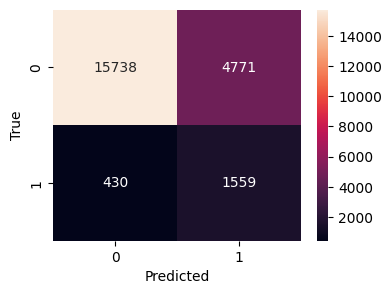

In [25]:
import xgboost as xgb
from sklearn.metrics import classification_report

params = {
    'objective': 'binary:logistic',  
    'max_depth': 20,
    'learning_rate': 0.05,
    #'scale_pos_weight': neg_to_pos_ratio,

}
num_rounds = 1000  # Number of boosting rounds

for subset_i in range(len(cloud_type_fractions)): # X_subset, y_subset in zip(X_subsets, y_subsets):
    #X_sub_train, X_sub_val, y_sub_val, y_sub_val = train_test_split(X_subset, y_subset, test_size=(1/19))

    dtrain = xgb.DMatrix(X_subsets[subset_i], label=y_subsets[subset_i])
    dtest = xgb.DMatrix(X_test_scaled_noisy, label=y_test_class)
    
    model = xgb.train(params, dtrain, num_rounds)
    predictions = model.predict(dtest)
    y_pred_class = (predictions > 0.5).astype(int) 

    print(f'Cloud type fractions: {cloud_type_fractions[subset_i]}')
    print(classification_report(y_test_class, y_pred_class))
    cm = confusion_matrix(y_test_class, y_pred_class)
    plt.figure(figsize=(4,3)) 
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     20457
           1       0.57      0.30      0.39      2041

    accuracy                           0.92     22498
   macro avg       0.75      0.64      0.67     22498
weighted avg       0.90      0.92      0.90     22498



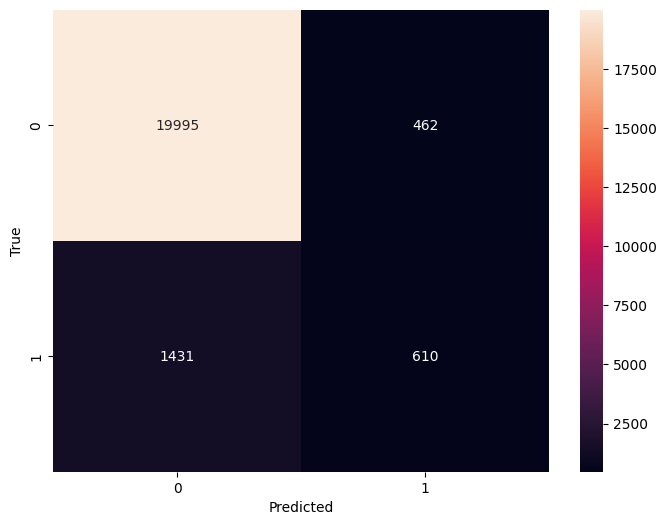

In [25]:
import xgboost as xgb
from sklearn.metrics import classification_report

neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)

dtrain = xgb.DMatrix(X_train_scaled_noisy, label=y_train_class)
dtest = xgb.DMatrix(X_test_scaled_noisy, label=y_test_class)

params = {
    'objective': 'binary:logistic',  # For binary classification
    'max_depth': 30,  # Maximum tree depth
    'learning_rate': 0.1,  # Learning rate
    'scale_pos_weight': neg_to_pos_ratio,
   # ... other parameters (Refer to XGBoost documentation)
}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
predictions = model.predict(dtest)
y_pred_class = (predictions > 0.5 ).astype(int) 

print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_train_reg_scaled = target_scaler.fit_transform(y_train_reg.reshape(-1, 1))


# First split: Separate out a test set (5% of the original dataset)
X_temp, X_test, y_temp, y_test_reg = train_test_split(X_train_scaled, y_train_reg_scaled, test_size=(1/20))
test_set_i = np.random.choice(len(y_train_reg), int(0.05 * len(y_train_reg)), replace=False)



if LOW_VIS_FRAC:
    low_vis_i = np.where(target_scaler.inverse_transform(y_temp) < low_vis_threshold)[0]
    high_vis_i = np.where(target_scaler.inverse_transform(y_temp) >= low_vis_threshold)[0]
    n_high_vis = int(len(low_vis_i) / low_vis_frac * (1 - low_vis_frac))
    print(f'real frac: {len(low_vis_i)/len(y_train_reg_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)
    X_temp = np.vstack([X_temp[low_vis_i], X_temp[r_high_vis_i]])
    y_temp = np.vstack([y_temp[low_vis_i], y_temp[r_high_vis_i]])
  

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train_reg, y_val = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_label = np.where(target_scaler.inverse_transform(y_train_reg) < low_vis_threshold, 1, 0)
y_val_label = np.where(target_scaler.inverse_transform(y_val) < low_vis_threshold, 1, 0)
y_test_label = np.where(target_scaler.inverse_transform(y_test_reg) < low_vis_threshold, 1, 0)


# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_reg)).batch(batch_size=dnn_batch_size)
training_data_classes = tf.data.Dataset.from_tensor_slices((X_train, y_train_label)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_classes = training_data_classes.map(noise_map)

In [18]:
import rasterio

# Open the TIFF file
with rasterio.open('MODISMondlyFLCC_2000-06.b1.tif') as src:
    image_array = src.read()  # Reads all bands by default

# Check the shape and data type
print(image_array.shape)
print(image_array.dtype)

(1, 1124, 984)
float32


In [30]:
import numpy as np

cloud_type_fracs = np.random.uniform(size=(1,6)) # Excluding mixed tyes now
cloud_type_fracs = cloud_type_fracs / np.sum(cloud_type_fracs)

print(cloud_type_fracs)

[[0.20838406 0.16794137 0.07650787 0.20643316 0.16301407 0.17771947]]
